### Import libraries

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


### Input & Output creation

In [ ]:
# read file and create ouput file
input = 'C:/welead/project/project_root/data/mpg_data.xlsx'
output = 'C:/welead/project/project_root/'
if not os.path.exists(output):
    os.makedirs(output)
    
    sys.exit()
df = pd.read_excel(input)



In [3]:
# car name (last column) is ommitted, it does not add any value since all values are distinct
df = df.iloc[:, 0:8]
print(df.info())
print(df.describe())
df = df.drop_duplicates()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406 entries, 0 to 405
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     406 non-null    int64  
 2   displayments  406 non-null    float64
 3   horsepower    400 non-null    float64
 4   weight        406 non-null    int64  
 5   acceleration  406 non-null    float64
 6   model year    406 non-null    int64  
 7   origin        406 non-null    int64  
dtypes: float64(4), int64(4)
memory usage: 25.5 KB
None
              mpg   cylinders  displayments  horsepower       weight  \
count  398.000000  406.000000    406.000000  400.000000   406.000000   
mean    23.514573    5.475369    194.779557  105.082500  2979.413793   
std      7.815984    1.712160    104.922458   38.768779   847.004328   
min      9.000000    3.000000     68.000000   46.000000  1613.000000   
25%     17.500000    4.000000    105.000000   75.7

### Fill NaN values With linear regression

In [4]:
# correlation matrix for all columns
# correlation is not affected by scaling, so we can use the original data
correlation_all = df.corr()
print("Correlation matrix:\n", correlation_all)

Correlation matrix:
                    mpg  cylinders  displayments  horsepower    weight  \
mpg           1.000000  -0.775396     -0.804203   -0.778427 -0.831741   
cylinders    -0.775396   1.000000      0.951787    0.844158  0.895220   
displayments -0.804203   0.951787      1.000000    0.898326  0.932475   
horsepower   -0.778427   0.844158      0.898326    1.000000  0.866586   
weight       -0.831741   0.895220      0.932475    0.866586  1.000000   
acceleration  0.420289  -0.522452     -0.557984   -0.697124 -0.430086   
model year    0.579267  -0.360762     -0.381714   -0.424419 -0.315389   
origin        0.563450  -0.567478     -0.613056   -0.460033 -0.584109   

              acceleration  model year    origin  
mpg               0.420289    0.579267  0.563450  
cylinders        -0.522452   -0.360762 -0.567478  
displayments     -0.557984   -0.381714 -0.613056  
horsepower       -0.697124   -0.424419 -0.460033  
weight           -0.430086   -0.315389 -0.584109  
acceleration   

In [5]:
# avoid self correlation
np.fill_diagonal(correlation_all.values, np.nan)

# Select features with high correlation to mpg (e.g., >0.5 or <-0.5)
high_corr_feat_mpg = correlation_all.index[abs(correlation_all['mpg']) > 0.5].tolist()
print("Highly correlated features with mpg:", high_corr_feat_mpg)

Highly correlated features with mpg: ['cylinders', 'displayments', 'horsepower', 'weight', 'model year', 'origin']


In [6]:
# Select features with high correlation to horsepower (e.g., >0.5 or <-0.5)
high_corr_feat_hp = correlation_all.index[abs(correlation_all['horsepower']) > 0.5].tolist()
print("Highly correlated features with horsepower:", high_corr_feat_hp)

Highly correlated features with horsepower: ['mpg', 'cylinders', 'displayments', 'weight', 'acceleration']


##### One-hot encoding for the 'origin' column

In [7]:
#One-hot encoding for the 'origin' column
enc = OneHotEncoder()
origin_enc = enc.fit_transform(df[['origin']]).toarray()
origin_enc = pd.DataFrame(origin_enc, columns=['origin_1', 'origin_2', 'origin_3'])
df = pd.concat([df, origin_enc], axis=1)
df.drop('origin', axis=1, inplace=True)
print("\nData Preview after one-hot encoding:")
print(df.head())


Data Preview after one-hot encoding:
    mpg  cylinders  displayments  horsepower  weight  acceleration  \
0  18.0          8         307.0       130.0    3504          12.0   
1  15.0          8         350.0       165.0    3693          11.5   
2  18.0          8         318.0       150.0    3436          11.0   
3  16.0          8         304.0       150.0    3433          12.0   
4  17.0          8         302.0       140.0    3449          10.5   

   model year  origin_1  origin_2  origin_3  
0          70       1.0       0.0       0.0  
1          70       1.0       0.0       0.0  
2          70       1.0       0.0       0.0  
3          70       1.0       0.0       0.0  
4          70       1.0       0.0       0.0  


#MINI MODELING 1 (filling NaNs for horsepower)

In [8]:
# dropna rows to train the model
training_hp = df.dropna(subset=['horsepower'])

# dependent and independent variables - ommit mpg column because it contains NaNs
X_train_hp = training_hp[['cylinders', 'displayments', 'weight', 'acceleration']]  
y_train_hp = training_hp['horsepower']  

# lrm 1
modeling1 = LinearRegression()
modeling1.fit(X_train_hp, y_train_hp)

# let's predict

#find the nan values
nullvalues_hp = df[df['horsepower'].isnull()]

#prediction based on mpg, cylinders, displayments, weight, acceleration
X_test_hp = nullvalues_hp[['cylinders', 'displayments', 'weight', 'acceleration']] 

# predict missing values
df.loc[df['horsepower'].isnull(), 'horsepower'] = modeling1.predict(X_test_hp)

# check
print("Missing values after imputation (horsepower):\n", df['horsepower'].isnull().sum())

Missing values after imputation (horsepower):
 0


In [9]:
#checking the performance 
cv_scores = cross_val_score(modeling1, X_train_hp, y_train_hp, scoring='neg_mean_squared_error', cv=5)
cv_rmse = np.sqrt(-cv_scores)

print("Cross-Validation Results:")
print(f"RMSE (Fold-wise): {cv_rmse}")
print(f"Mean RMSE: {cv_rmse.mean():.2f}\n")
print('Min horsepower: ', df['horsepower'].min())
print('Max horsepower: ', df['horsepower'].max())
print(f"\nPercentage of RMSE: {cv_rmse.mean()/(df['horsepower'].max()-df['horsepower'].min())*100:.2f}%")
#r2 score
r2_hp = modeling1.score(X_train_hp, y_train_hp)
print(f"\nR2 score for horsepower: {r2_hp:.2f}")

Cross-Validation Results:
RMSE (Fold-wise): [20.31464256 13.35611581 11.18587782 10.0009747  10.10318841]
Mean RMSE: 12.99

Min horsepower:  46.0
Max horsepower:  230.0

Percentage of RMSE: 7.06%

R2 score for horsepower: 0.89


#MINI MODELING 2 (filling NaNs for mpg)

In [10]:
# dropna to train the model
training_mpg = df.dropna(subset=['mpg'])

# dependent and independent variables - ommit horsepower column because it contains predicted values replacing initial NaNs
# Highly correlated features with mpg include origin, therefore we will use the encoded form of origin to feed the model
X_train_mpg = training_mpg[['cylinders', 'displayments', 'weight', 'model year', 'origin_1', 'origin_2', 'origin_3']]  
y_train_mpg = training_mpg['mpg']  

# lrm 2
modeling2 = LinearRegression()
modeling2.fit(X_train_mpg, y_train_mpg)

# let's predict

#find the nan values
nullvalues_mpg= df[df['mpg'].isnull()]  

#prediction based on horsepower, weight, cylinders, model year, displayments
X_test_mpg = nullvalues_mpg[['cylinders', 'displayments', 'weight', 'model year', 'origin_1', 'origin_2', 'origin_3']]   
df.loc[df['mpg'].isnull(), 'mpg'] = modeling2.predict(X_test_mpg)

# final check
print("Missing values after imputation (MPG):\n", df['mpg'].isnull().sum())


Missing values after imputation (MPG):
 0


In [11]:
#check performance 

cv_scores = cross_val_score(modeling2, X_train_mpg, y_train_mpg, scoring='neg_mean_squared_error', cv=5)
cv_rmse = np.sqrt(-cv_scores)

print("Cross-Validation Results:")
print(f"RMSE (Fold-wise): {cv_rmse}")
print(f"Mean RMSE: {cv_rmse.mean():.2f}\n")
print('Min mpg: ', df['mpg'].min())
print('Max mpg: ', df['mpg'].max())
print(f"\nPercentage of RMSE: {cv_rmse.mean()/(df['mpg'].max()-df['mpg'].min())*100:.2f}%")
#r2 score
print(f"\nR2 score: {modeling2.score(X_train_mpg, y_train_mpg):.2f}")

Cross-Validation Results:
RMSE (Fold-wise): [3.56923229 3.16401514 2.56685036 3.95437034 5.23517184]
Mean RMSE: 3.70

Min mpg:  9.0
Max mpg:  46.6

Percentage of RMSE: 9.83%

R2 score: 0.82


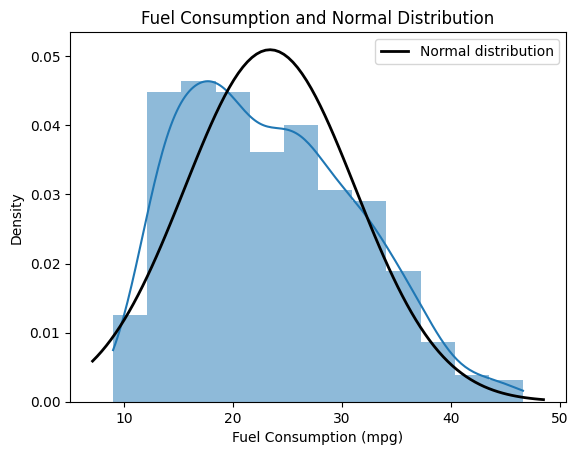

In [12]:
# Plot mpg vs normal distribution (after nan handling)
mpg = df['mpg']

# Create the histogram with a trendline
sns.histplot(mpg, kde=True, stat="density", linewidth=0)

# Fit a normal distribution to the data
mu, std = norm.fit(mpg)

# Plot the normal distribution line
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label='Normal distribution')

# Add labels and legend
plt.xlabel('Fuel Consumption (mpg)')
plt.ylabel('Density')
plt.title('Fuel Consumption and Normal Distribution')
plt.legend()
plt.savefig(os.path.join(output, 'fueldistrib.png' ))

# Show the plot
plt.show()

### Turn the Regression Problem to a Classification Problem

### Divide the classes

In [13]:
# Calculate quartiles
q1 = df["mpg"].quantile(0.25)
q2 = df["mpg"].quantile(0.50)  # Median
q3 = df["mpg"].quantile(0.75)

# Calculate IQR (InterQuartile Range)
iqr = q3 - q1

# Define outlier bounds
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Identify outliers
outliers = df[(df["mpg"] < lower_bound) | (df["mpg"] > upper_bound)]
print(f'Outliers: {outliers["mpg"].tolist()}') # No outliers found in the mpg column



Outliers: []


In [14]:
# Define bins and labels
bins = [float("-inf"), q1, q2, q3, float("inf")]  # Covers full range
labels = [0, 1, 2, 3]  # 0: Low, 1: Medium-Low, 2: Medium-High, 3: High

# Convert mpg to classes - we will use df_clean if we remove the outliers
df["mpg_classes"] = pd.cut(df["mpg"], bins=bins, labels=labels)

# Show class distribution
print(df["mpg_classes"].value_counts())

mpg_classes
2    105
0    104
1     99
3     98
Name: count, dtype: int64


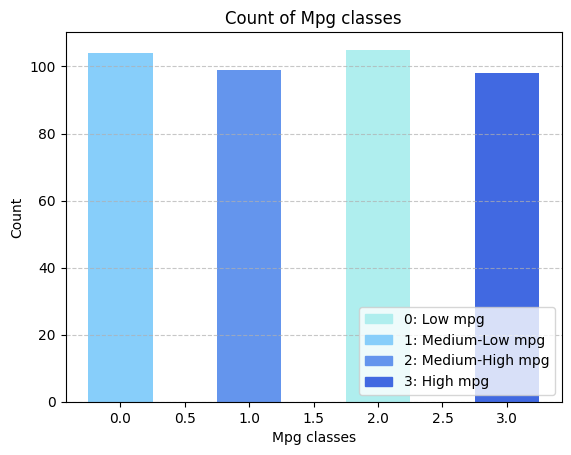

In [15]:
# Get the categories and counts
categories = df['mpg_classes'].value_counts().index
counts = df['mpg_classes'].value_counts().values  # Use .values to get the count as an array

blue_palette = ["paleturquoise", "lightskyblue", "cornflowerblue", "royalblue"]

# Define colored legend patches
low = mpatches.Patch(color=blue_palette[0], label='0: Low mpg')
medium_low = mpatches.Patch(color=blue_palette[1], label='1: Medium-Low mpg')
medium_high = mpatches.Patch(color=blue_palette[2], label='2: Medium-High mpg')
high = mpatches.Patch(color=blue_palette[3], label='3: High mpg')

# Plot the bar chart to see if data has been evenly distributed to the four bins
plt.bar(categories, counts, width=0.5, color=blue_palette)
plt.xlabel('Mpg classes')
plt.ylabel('Count')
plt.title('Count of Mpg classes')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(handles=[low, medium_low, medium_high, high], loc='lower right')
plt.show()

In [16]:
#Export the curated dataset
if not os.path.exists(output):
    os.makedirs(output)

output_file = os.path.join(output, 'curated_dataset.csv')
df.to_csv(output_file, index=False)
print(f"Curated dataset saved to {output_file}")

Curated dataset saved to C:/welead/project/curated_dataset.csv
